# Unsupervised methods : label creation for scalar measures

Recently I have been exploring unsupervised labeling methods. There are many ways to construct a label for data based on different criteria : 1) feature space exploration using clustering like kmeans (which is ordering data based on the mode, because distances are chosen based on random organization. Thus, mode values of the data are the predominate clusters regardless of ordering.), 2) labeling based on outliers with respect to the data mean, 3) labeling based on the frequency of the ordered data. Similarly, for time-series or image data, measures like similarity or correlation with respect to a desired pattern (based on PCA, CCA, etc) could be used to assign labels in an unsupervised manner.

In this "practice", I look at the first three unsupervised methods using the iris sklearn dataset.

<img src="main_splash.png" alt="Drawing" style="width: 300px;"/>

In [3]:
import numpy as np

import sys
sys.path.insert(1, 'C:\\...')

from subfunctions.scikit_functions_binaryclass import *
from subfunctions.scikit_functions import *

from sklearn import cluster

import warnings
warnings.filterwarnings('ignore')

# Toy example : Multi-class case (3 classes)

In [1]:
# -------------
# Toy example : Multi-class case 
# -------------

from sklearn import datasets
iris = datasets.load_iris()
X = iris.data  # we only take the first two features.
y = iris.target
# OR
X, y = datasets.load_iris(return_X_y=True)

X = iris.data[:, :2]  # we only take the first two features to reduct

# Way 0 : clustering

## Clustering with kmeans

In [2]:
def unsupervised_lab_kmeans_clustering(*arg):
    
    n_clusters = arg[0]
    X = arg[1]
    
    from sklearn import cluster
    
    kmeans = cluster.KMeans(n_clusters=n_clusters, init='k-means++',algorithm='elkan', random_state=2)
    
    # ------------------------------
    
    # print('shape of X : ', X.shape)
    kmeans.fit(X)

    # ------------------------------

    # Get the prediction of each category : predicted label
    label = kmeans.labels_
    # print('clusters_out : ' + str(clusters_out))
    # OR
    label = kmeans.predict(X)
    # print('clusters_out : ' + str(clusters_out))
    # print('length of clusters_out', len(clusters_out))
    
    # ------------------------------
    
    # Centroid values for feature space : this is the center cluster value per feature in X
    centroids = kmeans.cluster_centers_
    # print('centroids org : ' + str(centroids))

    # ------------------------------
    
    if len(arg) > 2:
        y = arg[2]
        
        # Accuracy percentage : classification
        cor = 0
        n_samples = y.shape[0]
        for i in range(0,n_samples):
            if np.sum(label[i] - y[i]) == 0:
                cor = cor + 1
        print("Accuracy between predicted label and true label: " + str((cor/n_samples)*100) + "%")

    return kmeans, label, centroids

In [3]:
n_classes = np.unique(y)
print('n_classes : ', n_classes)

n_clusters = 3
kmeans, label, centroids = unsupervised_lab_kmeans_clustering(n_clusters, X, y)

NameError: name 'np' is not defined

## 2D visual of clusters

(1.5, 4.9)

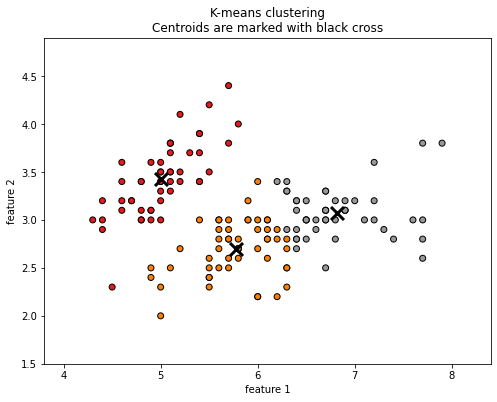

In [7]:
import matplotlib.pyplot as plt
plt.figure(2, figsize=(8, 6))
plt.clf()

# Can only plot two features at a time : select which 2 to look at
n_st_feat = 0
n_end_feat = 1

x_min, x_max = np.min(X[:,n_st_feat]) - 0.5, np.max(X[:,n_st_feat]) + 0.5
y_min, y_max = np.min(X[:,n_end_feat]) - 0.5, np.max(X[:,n_end_feat]) + 0.5


# Plot the first two feature
plt.scatter(X[:,n_st_feat], X[:,n_end_feat], c=label, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("feature 1")
plt.ylabel("feature 2")

# Plot the centroid for each class
plt.scatter(centroids[:,n_st_feat], centroids[:,n_end_feat],marker="x", s=169, linewidths=3, color="k", zorder=10)
    
plt.title("K-means clustering\n" "Centroids are marked with black cross")

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())
# plt.show()

# Way 1 : Label the data by significance to population mean : outliers as a detector

In [22]:
def unsupervised_lab_mean_sig(*arg):
    
    X = arg[0]
    
    # Creates a binary label only
    
    # ------------------------------
    num_of_feat = X.shape[1]

    datm = np.mean(X)
    dat_std = np.std(X)

    p_thresh = datm + dat_std
    n_thresh = datm - dat_std

    # ------------------------------
    
    import plotly.graph_objects as go
    fig = go.Figure()
    config = dict({'scrollZoom': True, 'displayModeBar': True, 'editable': True})

    # All initial slope estimates
    xxORG = list(range(X.shape[0]))
    for i in range(X.shape[1]):
        fig.add_trace(go.Scatter(x=xxORG, y=X[:,i], name='X', mode='markers', marker=dict(size=10, symbol=5, line=dict(color='black', width=0)), showlegend=True))

    mean_line = datm*np.ones((len(xxORG),1))
    mean_line = np.ravel(mean_line)
    fig.add_trace(go.Scatter(x=xxORG, y=mean_line, name='mean_line', line = dict(color='black', width=1, dash='dash'), showlegend=True))

    pos_thresh = p_thresh*np.ones((len(xxORG),1))
    pos_thresh = np.ravel(pos_thresh)
    fig.add_trace(go.Scatter(x=xxORG, y=pos_thresh, name='pos_thresh', line = dict(color='blue', width=1, dash='dash'), showlegend=True))

    neg_thresh = n_thresh*np.ones((len(xxORG),1))
    neg_thresh = np.ravel(neg_thresh)
    fig.add_trace(go.Scatter(x=xxORG, y=neg_thresh, name='neg_thresh', line = dict(color='blue', width=1, dash='dash'), showlegend=True))
    
    title_str = 'All data'
    fig.update_layout(title=title_str, xaxis_title='data points', yaxis_title='data')
    fig.show(config=config)

    # ------------------------------

    tot = []
    for nn in range(num_of_feat):
        vv = X[:,nn]
        label = []
        for i in vv:
            if i > p_thresh or i < n_thresh:
                label.append(1)  # outlier from mean
            else:
                label.append(0)  # mean

        tot.append(label)

    tot = np.transpose(tot)

    # ------------------------------
    
    # If features come from different distributions (NOT statistically similar (distribution, variance))
    # You can not stack the data/labels, must decide on which label to choose
    tot = np.reshape(tot, (X.shape[0], X.shape[1]))
    label_mean = np.floor(np.sum(tot, axis=1)/tot.shape[1])
    
    # ------------------------------
    
    # module for counting values in a list
    from collections import Counter
    c = Counter(label_mean)
    
    counted_num = []
    count = []
    for cn, cout in c.most_common(len(c)):
        counted_num = counted_num + [cn]
        count = count + [cout]
    print('counted_num : ' + str(counted_num))
    print('count : ' + str(count))
    
    # ------------------------------
    
    if len(arg) > 1:
        y = arg[1]
        
        # Accuracy percentage : classification
        cor = 0
        n_samples = y.shape[0]
        for i in range(0,n_samples):
            if np.sum(label_mean[i] - y[i]) == 0:
                cor = cor + 1
        print("Accuracy between predicted label and true label: " + str((cor/n_samples)*100) + "%")

    
    return label_mean

In [23]:
label_mean = unsupervised_lab_mean_sig(X, y)

counted_num : [0.0, 1.0]
count : [121, 29]
Accuracy between predicted label and true label: 42.66666666666667%


# Way 2 : Regression fit the data to get cyclical pattern - label the data based on the periodic cycle

In [26]:
def unsupervised_lab_filter_cyclical(*arg):
    
    X = arg[0]
    
    # ------------------------------
    
    # Smoothing the data reduces the number of unique classes
    from scipy import signal
    bin_filtsig = []
    for i in range(X.shape[1]):
        n = 3   # filter order
        fs = 250 # data sampling frequency (Hz)
        fc = 5  # Cut-off frequency of the filter , if you want a binary class label fc=1, 3-class label fc=5
        w = fc / (fs / 2) # Normalize the frequency
        b, a = signal.butter(n, w, 'low')  # 3rd order
        filtsig = signal.filtfilt(b, a, X[:,i])

        bin_filtsig.append(np.floor(filtsig))

    # ------------------------------
    
    # Shift the binary signals vertically to have the same starting point
    bin_filtsig_shift = []
    for i in range(X.shape[1]):
        bin_filtsig_shift.append(bin_filtsig[i] - bin_filtsig[i][0])
    
    # ------------------------------
    
    # If features come from different distributions (NOT statistically similar (distribution, variance))
    # You can not stack the data/labels, must decide on which label to choose
    tot = np.reshape(bin_filtsig_shift, (X.shape[0], X.shape[1]))
    label_mean = np.floor(np.sum(tot, axis=1)/tot.shape[1])
    
    print('unique values : ', np.unique(label_mean))
    # ------------------------------
    
    # module for counting values in a list
    from collections import Counter
    c = Counter(label_mean)
    
    counted_num = []
    count = []
    for cn, cout in c.most_common(len(c)):
        counted_num = counted_num + [cn]
        count = count + [cout]
    print('counted_num : ' + str(counted_num))
    print('count : ' + str(count))
    
    # ------------------------------
    
    if len(arg) > 1:
        y = arg[1]
        
        # Accuracy percentage : classification
        cor = 0
        n_samples = y.shape[0]
        for i in range(0,n_samples):
            if np.sum(label_mean[i] - y[i]) == 0:
                cor = cor + 1
        print("Accuracy between predicted label and true label: " + str((cor/n_samples)*100) + "%")

    return label_mean, bin_filtsig

In [27]:
label_filt_cyc, bin_filtsig = unsupervised_lab_filter_cyclical(X, y)

unique values :  [-1.  0.  1.]
counted_num : [0.0, -1.0, 1.0]
count : [76, 44, 30]
Accuracy between predicted label and true label: 44.666666666666664%


# Visualization of data and labels

In [15]:
import plotly.graph_objects as go
fig = go.Figure()
config = dict({'scrollZoom': True, 'displayModeBar': True, 'editable': True})

xxORG = list(range(X.shape[0]))
for i in range(X.shape[1]):
    fig.add_trace(go.Scatter(x=xxORG, y=X[:,i], name='X[:,%d]' % i,  line=dict(width=1), showlegend=True))
    fig.add_trace(go.Scatter(x=xxORG, y=bin_filtsig[i], name='filtsig0',  line=dict(color='yellow', width=1), showlegend=True))

# Plot unsupervised labels
fig.add_trace(go.Scatter(x=xxORG, y=label, name='label',  line=dict(color='blue', width=1), showlegend=True))
fig.add_trace(go.Scatter(x=xxORG, y=label_mean, name='label_mean',  line=dict(color='green', width=1), showlegend=True))
fig.add_trace(go.Scatter(x=xxORG, y=label_filt_cyc, name='label_filt_cyc',  line=dict(color='magenta', width=1), showlegend=True))

title_str = 'All data'
fig.update_layout(title=title_str, xaxis_title='data points', yaxis_title='data')
fig.show(config=config)

# Prediction with real/ground-truth label

## True label

shape of X_train :  (112, 2)
shape of Y_train_1D :  (112,)
shape of X_test :  (38, 2)
shape of Y_test_1D :  (38,)


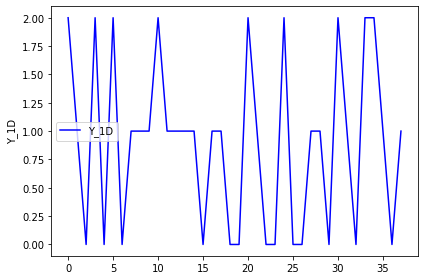

shape of Y_train_bin_pp :  (112, 3)
shape of Y_test_bin_pp :  (38, 3)
shape of Y_train_bin_score :  (112, 3)
shape of Y_test_bin_score :  (38, 3)
shape of Y_bin :  (112, 3)
shape of Y_bin :  (112, 3)
shape of Y_bin :  (112, 3)
shape of Y_bin_predict :  (112, 3)
prec_recall_f_dircalc :  (0.8303571428571429, 0.8303571428571429, 0.8303571428571429, None)
value_pack_train :  {'acc_crossval': array([0.82608696, 0.60869565, 0.68181818, 0.54545455, 0.72727273]), 'prec_crossval': array([nan, nan, nan, nan, nan]), 'recall_crossval': array([nan, nan, nan, nan, nan]), 'rocauc_ovo_crossval': array([nan, nan, nan, nan, nan]), 'roc_auc_ovo_weighted_crossval': array([nan, nan, nan, nan, nan]), 'acc_dircalc': 0.8303571428571429, 'prec_dircalc': 0.8303571428571429, 'recall_dircalc': 0.8303571428571429, 'f1_dircalc': 0.8303571428571429, 'fbeta_dircalc': 0.8303571428571429, 'prec_recall_f_dircalc': (0.8303571428571429, 0.8303571428571429, 0.8303571428571429, None), 'rocauc_pp_dircalc': 0.9281728316326531

In [12]:
# Multi-class case : 
X_train, X_test, Y_train_1D, Y_test_1D = do_train_test_split(X, y)

check_if_Y_1D_is_correct(Y_test_1D)

# multi-class Stochastic Gradient Descent
model, Y_train_1D_predict, Y_test_1D_predict, Y_train_bin_pp, Y_test_bin_pp, Y_train_bin_score, Y_test_bin_score = multiclass_stochastic_gradient_descent(X_train, X_test, Y_train_1D, Y_test_1D)

value_pack_train = evaluation_methods_multi_class_1D(model, X_train, Y_train_1D, Y_train_1D_predict, Y_train_bin_pp, Y_train_bin_score)
print('value_pack_train : ', value_pack_train)

value_pack_test = evaluation_methods_multi_class_1D(model, X_test, Y_test_1D, Y_test_1D_predict, Y_test_bin_pp, Y_test_bin_score)
print('value_pack_test : ', value_pack_test)

## Clustering label

shape of X_train :  (112, 2)
shape of Y_train_1D :  (112,)
shape of X_test :  (38, 2)
shape of Y_test_1D :  (38,)


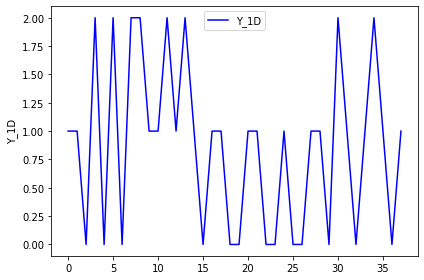

shape of Y_train_bin_pp :  (112, 3)
shape of Y_test_bin_pp :  (38, 3)
shape of Y_train_bin_score :  (112, 3)
shape of Y_test_bin_score :  (38, 3)
shape of Y_bin :  (112, 3)
shape of Y_bin :  (112, 3)
shape of Y_bin :  (112, 3)
shape of Y_bin_predict :  (112, 3)
prec_recall_f_dircalc :  (0.9553571428571429, 0.9553571428571429, 0.955357142857143, None)
value_pack_train :  {'acc_crossval': array([0.69565217, 0.91304348, 0.72727273, 0.68181818, 0.59090909]), 'prec_crossval': array([nan, nan, nan, nan, nan]), 'recall_crossval': array([nan, nan, nan, nan, nan]), 'rocauc_ovo_crossval': array([nan, nan, nan, nan, nan]), 'roc_auc_ovo_weighted_crossval': array([nan, nan, nan, nan, nan]), 'acc_dircalc': 0.9553571428571429, 'prec_dircalc': 0.9553571428571429, 'recall_dircalc': 0.9553571428571429, 'f1_dircalc': 0.9553571428571429, 'fbeta_dircalc': 0.955357142857143, 'prec_recall_f_dircalc': (0.9553571428571429, 0.9553571428571429, 0.955357142857143, None), 'rocauc_pp_dircalc': 0.9167330994897959, '

In [13]:
# Multi-class case : 
X_train, X_test, Y_train_1D, Y_test_1D = do_train_test_split(X, label)

check_if_Y_1D_is_correct(Y_test_1D)

# multi-class Stochastic Gradient Descent
model, Y_train_1D_predict, Y_test_1D_predict, Y_train_bin_pp, Y_test_bin_pp, Y_train_bin_score, Y_test_bin_score = multiclass_stochastic_gradient_descent(X_train, X_test, Y_train_1D, Y_test_1D)

value_pack_train = evaluation_methods_multi_class_1D(model, X_train, Y_train_1D, Y_train_1D_predict, Y_train_bin_pp, Y_train_bin_score)
print('value_pack_train : ', value_pack_train)

value_pack_test = evaluation_methods_multi_class_1D(model, X_test, Y_test_1D, Y_test_1D_predict, Y_test_bin_pp, Y_test_bin_score)
print('value_pack_test : ', value_pack_test)

## Mean significance label

shape of X_train :  (112, 2)
shape of Y_train_1D :  (112,)
shape of X_test :  (38, 2)
shape of Y_test_1D :  (38,)


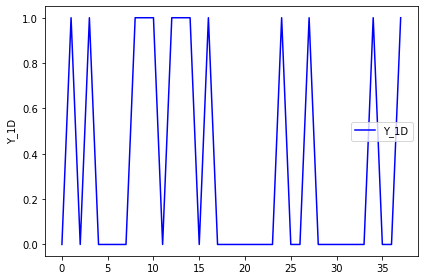

shape of Y_train_bin_pp :  (112, 2)
shape of Y_test_bin_pp :  (38, 2)
shape of Y_train_1D_score :  (112,)
shape of Y_test_1D_score :  (38,)
acc_crossval :  [0.91304348 0.69565217 0.90909091 0.95454545 0.86363636]
prec_crossval :  [0.   0.25 1.   0.   1.  ]
recall_crossval :  [0.         1.         0.33333333 0.         0.        ]
rocauc_crossval :  [0.93333333 0.96052632 0.87719298 1.         0.9122807 ]
matrix_of_counts :  [[94  2]
 [ 7  9]]
matrix_normalized :  [[0.83928571 0.01785714]
 [0.0625     0.08035714]]
acc_dircalc :  0.9196428571428571
prec_dircalc :  0.9196428571428571
recall_dircalc :  0.9196428571428571
f1_dircalc :  0.9196428571428571
fbeta_dircalc :  0.9196428571428571
prec_recall_f_dircalc :  (0.9196428571428571, 0.9196428571428571, 0.9196428571428571, None)
shape of Y_1D :  (112,)
shape of Y_1D_pp :  (112,)
rocauc_pp_dircalc :  0.06510416666666667
rocauc_df_dircalc :  0.9407552083333334
value_pack_train :  {'acc_crossval': array([0.91304348, 0.69565217, 0.90909091, 0

In [15]:
# Multi-class case : 
X_train, X_test, Y_train_1D, Y_test_1D = do_train_test_split(X, label_mean)

check_if_Y_1D_is_correct(Y_test_1D)

# 5) 2-class Stochastic Gradient Descent
model, Y_train_1D_predict, Y_test_1D_predict, Y_train_bin_pp, Y_test_bin_pp, Y_train_1D_score, Y_test_1D_score = binary_stochastic_gradient_descent(X_train, X_test, Y_train_1D, Y_test_1D)

value_pack_train = evaluation_methods_binary_class(model, X_train, Y_train_1D, Y_train_1D_predict, Y_train_bin_pp, Y_train_1D_score)
print('value_pack_train : ', value_pack_train)

value_pack_test = evaluation_methods_binary_class(model, X_test, Y_test_1D, Y_test_1D_predict, Y_test_bin_pp, Y_test_1D_score)
print('value_pack_test : ', value_pack_test)

## Filter cyclical label

shape of X_train :  (112, 2)
shape of Y_train_1D :  (112,)
shape of X_test :  (38, 2)
shape of Y_test_1D :  (38,)


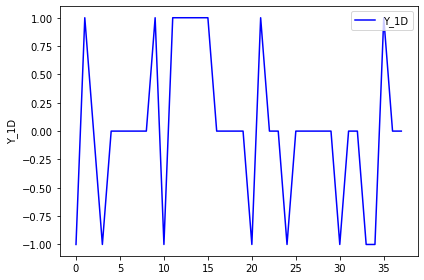

shape of Y_train_bin_pp :  (112, 3)
shape of Y_test_bin_pp :  (38, 3)
shape of Y_train_bin_score :  (112, 3)
shape of Y_test_bin_score :  (38, 3)
shape of Y_bin :  (112, 3)
shape of Y_bin :  (112, 2)
shape of Y_bin :  (112, 3)
shape of Y_bin_predict :  (112, 2)
prec_recall_f_dircalc :  (0.6696428571428571, 0.6696428571428571, 0.6696428571428571, None)
value_pack_train :  {'acc_crossval': array([0.52173913, 0.52173913, 0.27272727, 0.5       , 0.54545455]), 'prec_crossval': array([nan, nan, nan, nan, nan]), 'recall_crossval': array([nan, nan, nan, nan, nan]), 'rocauc_ovo_crossval': array([nan, nan, nan, nan, nan]), 'roc_auc_ovo_weighted_crossval': array([nan, nan, nan, nan, nan]), 'acc_dircalc': 0.6696428571428571, 'prec_dircalc': 0.6696428571428571, 'recall_dircalc': 0.6696428571428571, 'f1_dircalc': 0.6696428571428571, 'fbeta_dircalc': 0.6696428571428571, 'prec_recall_f_dircalc': (0.6696428571428571, 0.6696428571428571, 0.6696428571428571, None), 'rocauc_pp_dircalc': 0.7444993622448979

In [40]:
# Multi-class case : 
X_train, X_test, Y_train_1D, Y_test_1D = do_train_test_split(X, label_filt_cyc)

check_if_Y_1D_is_correct(Y_test_1D)

# multi-class Stochastic Gradient Descent
model, Y_train_1D_predict, Y_test_1D_predict, Y_train_bin_pp, Y_test_bin_pp, Y_train_bin_score, Y_test_bin_score = multiclass_stochastic_gradient_descent(X_train, X_test, Y_train_1D, Y_test_1D)

value_pack_train = evaluation_methods_multi_class_1D(model, X_train, Y_train_1D, Y_train_1D_predict, Y_train_bin_pp, Y_train_bin_score)
print('value_pack_train : ', value_pack_train)

value_pack_test = evaluation_methods_multi_class_1D(model, X_test, Y_test_1D, Y_test_1D_predict, Y_test_bin_pp, Y_test_bin_score)
print('value_pack_test : ', value_pack_test)